# 1. Configuración Inicial y Preparación del Entorno

In [1]:
# Cambia el directorio actual al directorio Mask_RCNN
%cd Mask_RCNN

/mnt/c/Users/User/Escritorio/Mask_RCNN


In [2]:
# Ignorar advertencias generales para una salida más limpia
import warnings
warnings.filterwarnings('ignore')

# Silenciar mensajes detallados y warnings internos de TensorFlow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Importar TensorFlow y configurar nivel de registro de errores mínimos
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

# Importar librerías generales necesarias
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import skimage
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics
import scipy.ndimage

# Definir el directorio raíz del proyecto (directorio actual)
ROOT_DIR = os.path.abspath("./")

# Añadir ROOT_DIR al PATH del sistema para importar módulos locales
sys.path.append(ROOT_DIR)

# Importar componentes esenciales del modelo Mask R-CNN
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Permitir que matplotlib muestre gráficos directamente en el notebook
%matplotlib inline

# Definir ruta del directorio donde se almacenarán logs y checkpoints del modelo
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Definir ruta del archivo con pesos preentrenados del modelo COCO
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Descargar pesos preentrenados si no existen en la ruta especificada
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# 2. Configuración del Modelo y Dataset

## 2.1. Definición de la Configuración de Entrenamiento

In [3]:
# Configuración personalizada para entrenar el modelo Mask R-CNN en nuestro dataset específico
class TeethConfig(Config):
    """Configuración personalizada derivada de la clase base Config para entrenar en nuestro dataset específico."""
    
    # Nombre identificativo de la configuración
    NAME = "teeth"

    # Número de GPUs utilizadas y cantidad de imágenes procesadas simultáneamente por cada GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Número total de clases (1 clase personalizada "teeth" + 1 clase adicional de fondo)
    NUM_CLASSES = 1 + 1  # Fondo (background) + clase teeth

    # Número de pasos de entrenamiento por cada época
    STEPS_PER_EPOCH = 100

# Crear una instancia con la configuración personalizada
config = TeethConfig()

# Mostrar la configuración actual
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        35
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## 2.2. Configuración de Visualización

In [4]:
# Función para crear figuras y ejes personalizados usando Matplotlib
def get_ax(rows=1, cols=1, size=8):
    """
    Crea una figura de Matplotlib con la cantidad especificada de filas y columnas de gráficos.
    
    Parámetros:
        rows (int): Número de filas de gráficos.
        cols (int): Número de columnas de gráficos.
        size (int): Tamaño de cada gráfico individual.
    
    Retorna:
        fig: Objeto figura de Matplotlib.
        ax: Array de ejes creados para los gráficos.
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return fig, ax

## 2.3. Preparación del Dataset

In [5]:
# Clase de dataset personalizada para el modelo Mask R-CNN en nuestro dataset específico
class TeethDataset(utils.Dataset):
    """Clase personalizada para gestionar el dataset específico de dientes, incluyendo carga de imágenes y máscaras para entrenamiento con Mask R-CNN."""

    def __init__(self, dataset_path):
        """Inicializa el dataset con la ruta especificada."""
        self.dataset_path = dataset_path
        super(TeethDataset, self).__init__()

    def load_teeth(self):
        """Carga las imágenes y máscaras del dataset para entrenamiento."""

        # Añadir la clase personalizada "tooth"
        self.add_class("teeth", 1, "tooth")

        # Directorios de imágenes y máscaras
        images_dir = os.path.join(self.dataset_path, "images")
        masks_dir = os.path.join(self.dataset_path, "masks")

        count = 0
        # Iterar sobre los archivos en la carpeta de imágenes
        for image_file in os.listdir(images_dir):
            if image_file.endswith(".jpg"):
                image_id = os.path.splitext(image_file)[0]
                image_path = os.path.join(images_dir, image_file)
                mask_path = os.path.join(masks_dir, f"{image_id}.png")

                # Verificar la existencia de la máscara correspondiente
                if os.path.exists(mask_path):
                    self.add_image(
                        "teeth",
                        image_id=count,
                        path=image_path,
                        image_path_id=image_id
                    )
                    count += 1

    def load_mask(self, image_id):
        """Carga y procesa las máscaras correspondientes a una imagen específica."""

        # Información de la imagen solicitada
        info = self.image_info[image_id]

        # Extraer el ID de la imagen sin extensión
        image_id_str = info['path'].split("/")[-1].split(".")[0]

        # Ruta de la máscara correspondiente
        path_mask = os.path.join(self.dataset_path, "masks", f"{image_id_str}.png")

        # Leer la máscara en escala de grises
        image_mask = skimage.io.imread(path_mask)

        # Binarizar máscara usando umbral
        ret, thresh = cv2.threshold(image_mask, 0, 255, 0)

        # Detectar contornos en la máscara
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Crear IDs de clase (todas las instancias son clase "tooth")
        class_ids = np.ones(len(contours), np.int32)

        # Crear un arreglo vacío para almacenar máscaras individuales
        masks = np.zeros((image_mask.shape[0], image_mask.shape[1], len(contours)), dtype=np.bool_)

        # Crear máscaras individuales a partir de cada contorno
        for i in range(len(contours)):
            # Imagen vacía para dibujar contorno actual
            img_cont = np.zeros((image_mask.shape[0], image_mask.shape[1], 3), dtype=image_mask.dtype)

            # Dibujar contorno actual en la imagen
            cv2.drawContours(img_cont, contours, i, (255, 255, 255), -1)

            # Convertir imagen de contorno a binaria
            bimask = img_cont[:, :, 0]

            # Aplicar umbralización para obtener máscara final
            thresh = skimage.filters.threshold_mean(bimask)
            mask = bimask > thresh

            # Guardar máscara individual en el arreglo de máscaras
            masks[:, :, i] = mask

        return masks, class_ids

In [6]:
# Rutas a los datasets de entrenamiento, validación y test
teeth_dataset_train_path = "/mnt/c/Users/User/Escritorio/Mask_RCNN/dataset/train"
teeth_dataset_val_path = "/mnt/c/Users/User/Escritorio/Mask_RCNN/dataset/val"
teeth_dataset_test_path = "/mnt/c/Users/User/Escritorio/Mask_RCNN/dataset/test"

# Cargar dataset de entrenamiento
teeth_dataset_train = TeethDataset(teeth_dataset_train_path)
teeth_dataset_train.load_teeth()  # Cargar imágenes y máscaras
teeth_dataset_train.prepare()     # Preparar dataset (índices internos)
print("Número de imágenes en Train:", len(teeth_dataset_train.image_ids))

# Cargar dataset de validación
teeth_dataset_val = TeethDataset(teeth_dataset_val_path)
teeth_dataset_val.load_teeth()    # Cargar imágenes y máscaras
teeth_dataset_val.prepare()       # Preparar dataset (índices internos)
print("Número de imágenes en Validation:", len(teeth_dataset_val.image_ids))

# Cargar dataset de prueba (test)
teeth_dataset_test = TeethDataset(teeth_dataset_test_path)
teeth_dataset_test.load_teeth()   # Cargar imágenes y máscaras
teeth_dataset_test.prepare()      # Preparar dataset (índices internos)
print("Número de imágenes en Test:", len(teeth_dataset_test.image_ids))

Número de imágenes en Train: 376
Número de imágenes en Validation: 87
Número de imágenes en Test: 80


## 2.4. Visualización del Dataset

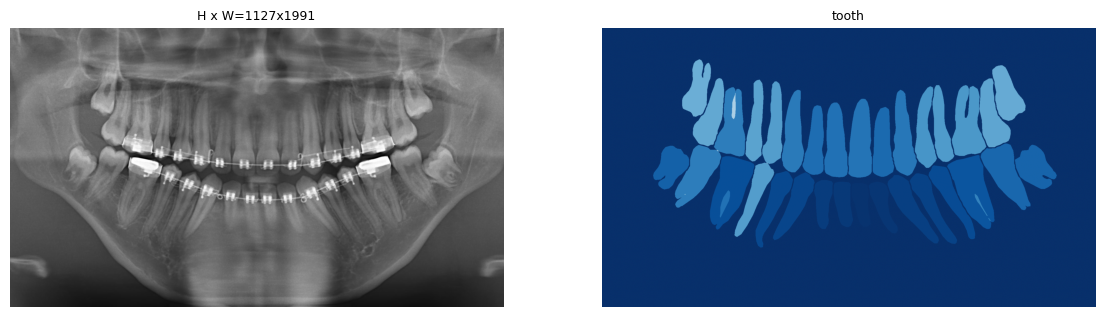

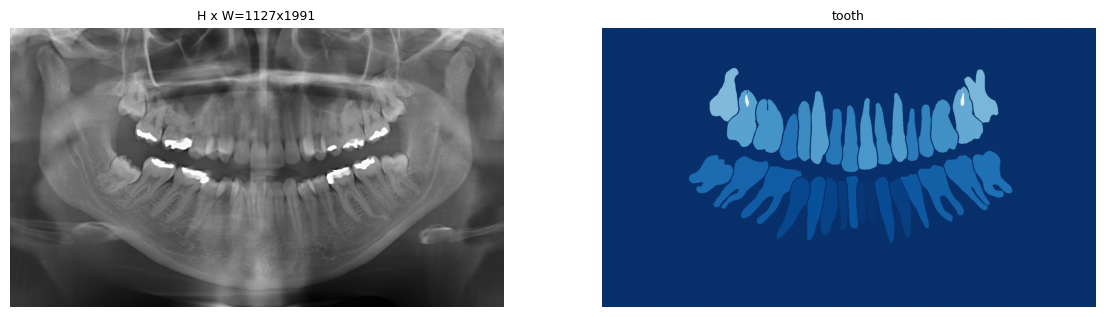

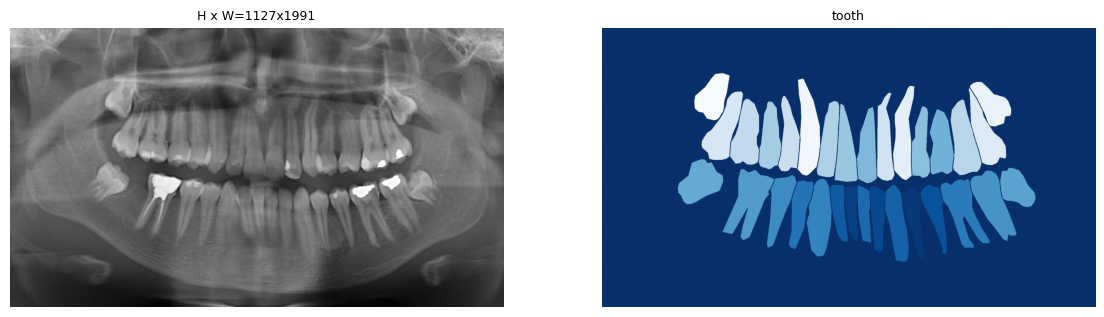

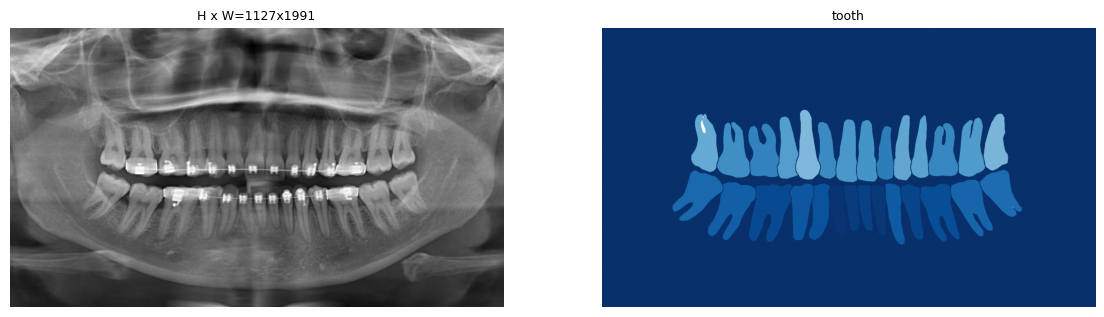

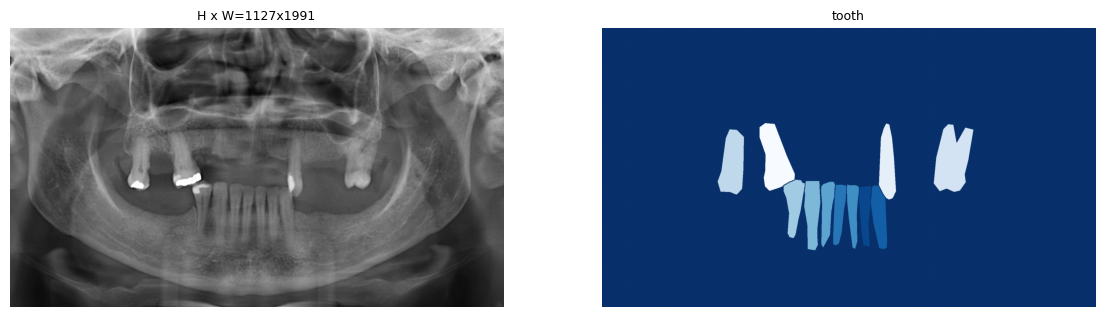

In [7]:
# Seleccionar aleatoriamente 5 imágenes del dataset de entrenamiento para visualizarlas
image_ids = np.random.choice(teeth_dataset_train.image_ids, 5)

# Mostrar imágenes junto con sus máscaras correspondientes
for image_id in image_ids:
    image = teeth_dataset_train.load_image(image_id)  # Cargar imagen
    mask, class_ids = teeth_dataset_train.load_mask(image_id)  # Cargar máscara asociada
    visualize.display_top_masks(
        image, mask, class_ids, teeth_dataset_train.class_names, limit=1
    )

# 3. Entrenamiento del Modelo

## 3.1. Inicialización del Modelo en Modo Entrenamiento

In [8]:
# Crear instancia del modelo Mask R-CNN en modo entrenamiento
model = modellib.MaskRCNN(
    mode="training",       # Establecer modo entrenamiento
    config=config,         # Usar configuración personalizada previamente definida
    model_dir=MODEL_DIR    # Directorio para guardar checkpoints y logs del modelo
)

## 3.2. Carga de Pesos Preentrenados

In [9]:
# Cargar pesos preentrenados del modelo COCO
# Excluir las capas específicas que difieren por el número personalizado de clases
model.load_weights(
    COCO_MODEL_PATH,          # Ruta del archivo de pesos preentrenados
    by_name=True,             # Cargar pesos según nombre de capas coincidentes
    exclude=[                 # Capas excluidas debido a diferencias en clases
        "mrcnn_class_logits",
        "mrcnn_bbox_fc",
        "mrcnn_bbox",
        "mrcnn_mask"
    ]
)

## 3.3. Entrenamiento de la Red

In [10]:
# Entrenar únicamente las capas superiores ("heads") del modelo
# Esto congela todas las demás capas del modelo y entrena solo las específicas para la tarea
model.train(
    teeth_dataset_train,                   # Dataset de entrenamiento
    teeth_dataset_val,                     # Dataset de validación
    learning_rate=config.LEARNING_RATE,    # Tasa de aprendizaje definida en la configuración
    epochs=100,                            # Número de épocas de entrenamiento
    layers='heads'                         # Indicar que solo se entrenarán las capas superiores
)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /mnt/c/Users/User/Escritorio/Mask_RCNN/logs/teeth20250311T2122/mask_rcnn_teeth_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (

## 3.4. Visualización de Pérdidas durante el Entrenamiento

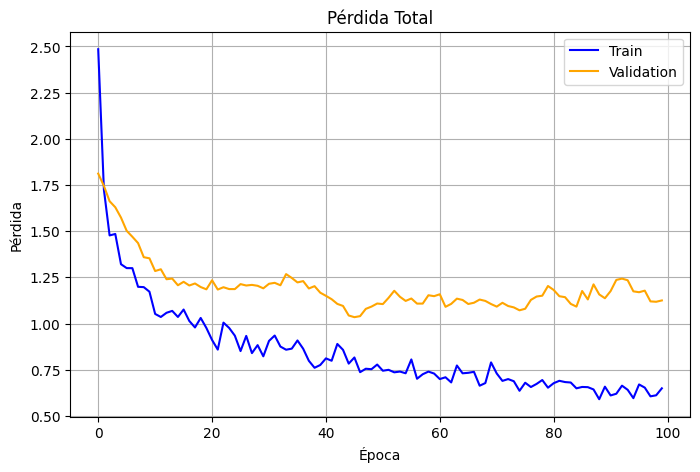

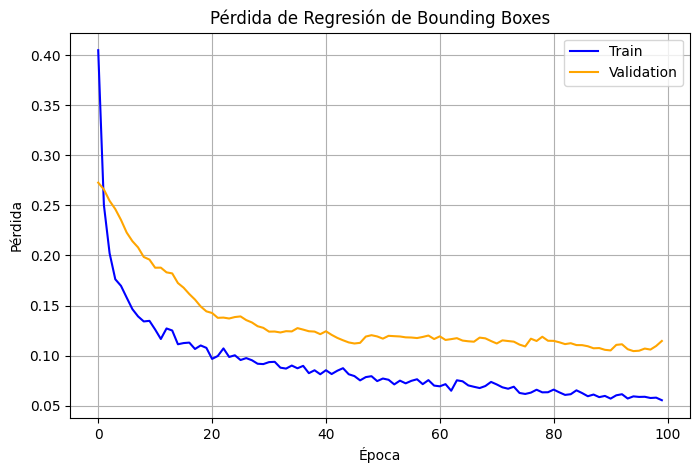

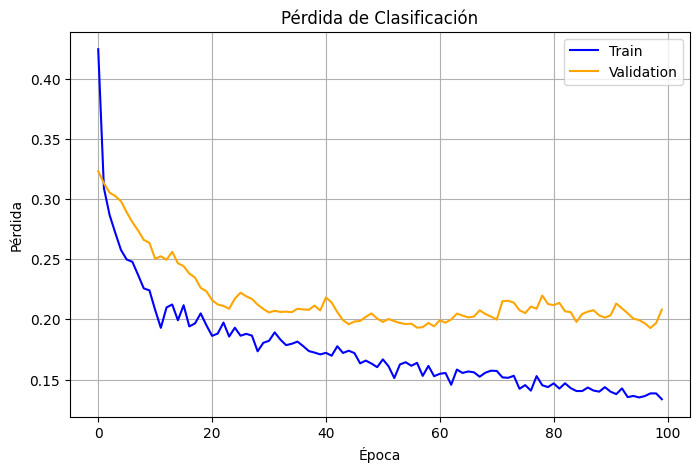

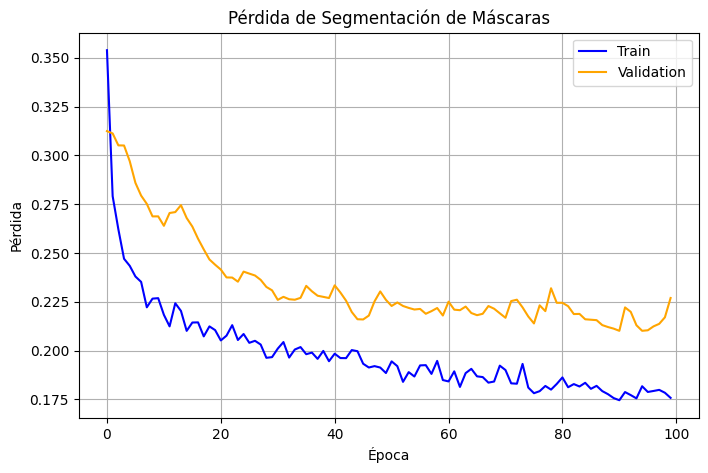

In [17]:
# Ruta al directorio de logs generado durante el entrenamiento
log_dir = "logs/teeth20250311T2122"

# Diccionario para almacenar las pérdidas registradas durante el entrenamiento
loss_tags = {
    "epoch_loss": ([], []),                     # Pérdida total en cada época (Train y Validation)
    "epoch_val_loss": ([], []),
    "epoch_mrcnn_bbox_loss": ([], []),          # Pérdida de regresión de bounding boxes
    "epoch_val_mrcnn_bbox_loss": ([], []),
    "epoch_mrcnn_class_loss": ([], []),         # Pérdida de clasificación
    "epoch_val_mrcnn_class_loss": ([], []),
    "epoch_mrcnn_mask_loss": ([], []),          # Pérdida de segmentación de máscaras
    "epoch_val_mrcnn_mask_loss": ([], [])
}

# Filtrar archivos de eventos generados por TensorBoard
event_files = [f for f in os.listdir(log_dir) if f.startswith("events.out.tfevents")]

# Leer y extraer datos de los archivos de eventos
for event_file in event_files:
    event_path = os.path.join(log_dir, event_file)
    try:
        for event in tf.compat.v1.train.summary_iterator(event_path):
            for value in event.summary.value:
                if value.tag in loss_tags:
                    steps, loss_values = loss_tags[value.tag]
                    steps.append(event.step)           # Guardar número de época
                    loss_values.append(value.simple_value)  # Guardar valor de pérdida correspondiente
    except tf.errors.DataLossError:
        print(f"Archivo corrupto ignorado: {event_file}")

# Función para graficar la evolución de las pérdidas durante el entrenamiento y la validación
def plot_loss(train_steps, train_loss, val_steps, val_loss, title):
    """
    Genera un gráfico que muestra la evolución de la pérdida a lo largo de las épocas para
    los conjuntos de entrenamiento y validación.
    
    Parámetros:
        train_steps (list o array): Lista de números de época o pasos para el entrenamiento.
        train_loss (list o array): Lista de valores de pérdida correspondientes a cada época del entrenamiento.
        val_steps (list o array): Lista de números de época o pasos para la validación.
        val_loss (list o array): Lista de valores de pérdida correspondientes a cada época de validación.
        title (str): Título del gráfico.
    """
    plt.figure(figsize=(8, 5))
    
    if len(train_steps) > 0:
        plt.plot(train_steps, train_loss, label="Train", color="blue")  # Pérdida en entrenamiento
    if len(val_steps) > 0:
        plt.plot(val_steps, val_loss, label="Validation", color="orange")  # Pérdida en validación
    
    plt.xlabel("Época")
    plt.ylabel("Pérdida")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Graficar pérdidas específicas a lo largo del entrenamiento
plot_loss(*loss_tags["epoch_loss"], *loss_tags["epoch_val_loss"], "Pérdida Total")
plot_loss(*loss_tags["epoch_mrcnn_bbox_loss"], *loss_tags["epoch_val_mrcnn_bbox_loss"], "Pérdida de Regresión de Bounding Boxes")
plot_loss(*loss_tags["epoch_mrcnn_class_loss"], *loss_tags["epoch_val_mrcnn_class_loss"], "Pérdida de Clasificación")
plot_loss(*loss_tags["epoch_mrcnn_mask_loss"], *loss_tags["epoch_val_mrcnn_mask_loss"], "Pérdida de Segmentación de Máscaras")

# 4. Configuración para Inferencia y Evaluación

## 4.1. Configuración del Modo Inferencia

In [7]:
# Configuración personalizada para inferir el modelo Mask R-CNN en nuestro dataset específico
class InferenceConfig(TeethConfig):
    """Configuración personalizada derivada de la clase base Config para inferir en nuestro dataset específico."""
    GPU_COUNT = 1            # Número de GPUs a usar durante la inferencia
    IMAGES_PER_GPU = 1       # Número de imágenes procesadas por GPU

# Crear instancia de configuración de inferencia
inference_config = InferenceConfig()

# Crear nuevamente el modelo, ahora en modo inferencia
model = modellib.MaskRCNN(
    mode="inference",            # Configurar en modo inferencia
    config=inference_config,     # Usar configuración de inferencia
    model_dir=MODEL_DIR          # Directorio donde se guardaron los checkpoints
)

# Obtener ruta al archivo con pesos entrenados
# Se puede especificar una ruta concreta o cargar el último checkpoint
model_path = model.find_last()

# Cargar los pesos entrenados al modelo
print("Cargando pesos desde", model_path)
model.load_weights(model_path, by_name=True)

Cargando pesos desde /mnt/c/Users/User/Escritorio/Mask_RCNN/logs/teeth20250311T2122/mask_rcnn_teeth_0100.h5
Re-starting from epoch 100


## 4.2. Prueba del Modelo en Imágenes de Test

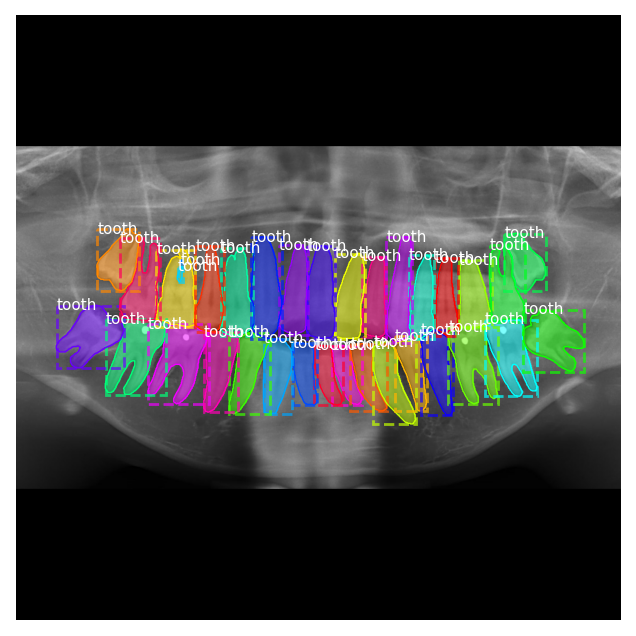

In [11]:
# Probar el modelo en una imagen aleatoria del conjunto de test
image_id = random.choice(teeth_dataset_test.image_ids)

# Cargar la imagen seleccionada y su información asociada (máscaras reales, IDs y bounding boxes)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(
    teeth_dataset_test, inference_config, image_id
)

# Visualizar la imagen original junto con sus máscaras y bounding boxes reales (ground truth)
visualize.display_instances(
    original_image,                   # Imagen original
    gt_bbox,                          # Bounding boxes reales (ground truth)
    gt_mask,                          # Máscaras reales
    gt_class_id,                      # IDs de clases reales
    teeth_dataset_train.class_names,  # Nombres de las clases
    figsize=(8, 8)                    # Tamaño de la figura
)

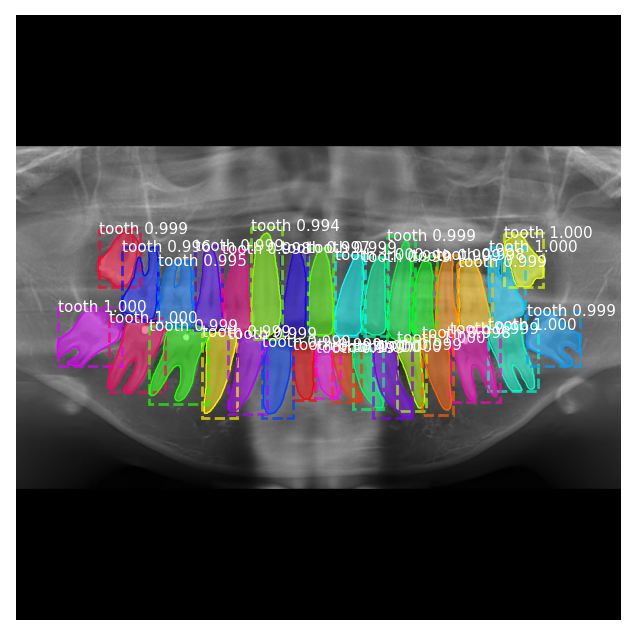

In [12]:
# Realizar predicción sobre la imagen seleccionada
results = model.detect([original_image])

# Obtener resultados de la predicción (detecciones, máscaras, clases y puntuaciones)
r = results[0]

# Visualizar resultados de la predicción (bounding boxes, máscaras, clases detectadas y scores)
visualize.display_instances(
    original_image,                  # Imagen original
    r['rois'],                       # Regiones detectadas (Bounding boxes)
    r['masks'],                      # Máscaras detectadas por el modelo
    r['class_ids'],                  # IDs de las clases detectadas
    teeth_dataset_test.class_names,  # Nombres de clases del dataset
    r['scores'],                     # Confianza (scores) del modelo para cada detección
    figAx=get_ax()                   # Crear figura con matplotlib
)

## 4.3. Evaluación del Modelo


- Métricas para Train:
Precision: 0.9881
Recall: 0.9561
F1-Score: 0.9718
AP@50: 0.9603

- Métricas para Validation:
Precision: 0.9618
Recall: 0.9377
F1-Score: 0.9496
AP@50: 0.9304

- Métricas para Test:
Precision: 0.9776
Recall: 0.9473
F1-Score: 0.9622
AP@50: 0.9464


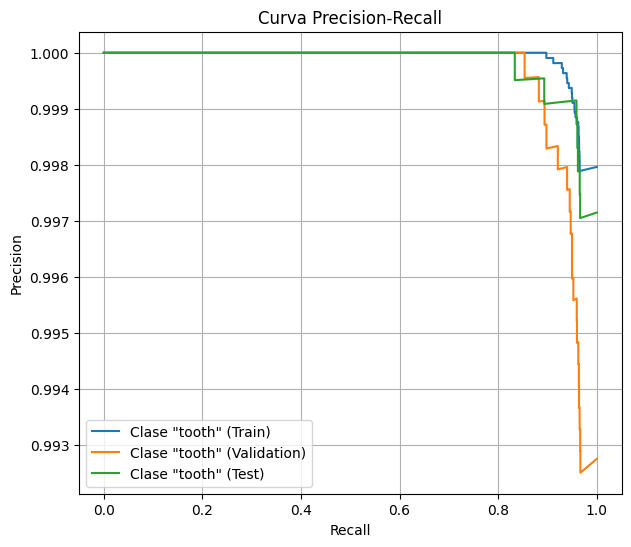

In [11]:
# Función para evaluar un dataset y calcular métricas
def evaluate_dataset(dataset, dataset_name):
    """
    Evalúa un conjunto de datos.
    
    Parámetros:
        dataset: Objeto que contiene las imágenes y sus anotaciones (por ejemplo, gt_bbox, gt_class_id, gt_mask).
        dataset_name (str): Nombre del conjunto de datos (por ejemplo, "Train", "Validation", "Test").
    
    Retorna:
        dict: Un diccionario con las métricas globales calculadas, que incluye:
              - "precision": Precisión global (TP / (TP + FP)).
              - "recall": Recall global (TP / (TP + FN)).
              - "f1_score": Valor F1-Score.
              - "AP@50": Promedio del Average Precision a IoU=0.5.
    """
    all_gt_labels = []
    all_pred_scores = []
    all_tp, all_fp, all_fn = 0, 0, 0  # TP, FP, FN acumulados
    APs_50 = []

    for image_id in dataset.image_ids:
        # Cargar imagen y anotaciones
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, inference_config, image_id)

        # Obtener predicciones del modelo
        results = model.detect([image], verbose=0)
        r = results[0]

        # Calcular AP@50
        AP_50, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                                                 r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs_50.append(AP_50)

        # Calcular TP, FP, FN
        gt_match, pred_match, overlaps = utils.compute_matches(gt_bbox, gt_class_id, gt_mask,
                                                                r["rois"], r["class_ids"], r["scores"], r['masks'],
                                                                iou_threshold=0.5)

        TP = np.sum(pred_match > -1)  # Detecciones correctas
        FP = np.sum(pred_match == -1)  # Falsos positivos
        FN = np.sum(gt_match == -1)  # Falsos negativos

        all_tp += TP
        all_fp += FP
        all_fn += FN

        # Obtener número de GT y predicciones
        num_gt = len(gt_class_id)
        num_pred = len(r['class_ids'])

        # Etiquetas reales (1 si hay objeto, 0 si no hay)
        gt_labels = np.ones(num_gt)

        # Puntuaciones de confianza de las predicciones
        pred_scores = r['scores'] if num_pred > 0 else np.array([])

        # Ajustar longitudes con np.pad()
        if num_gt > num_pred:
            pred_scores = np.pad(pred_scores, (0, num_gt - num_pred), constant_values=0)
        elif num_pred > num_gt:
            gt_labels = np.pad(gt_labels, (0, num_pred - num_gt), constant_values=0)

        # Guardar datos corregidos
        all_gt_labels.extend(gt_labels)
        all_pred_scores.extend(pred_scores)

    # Convertir listas a numpy arrays
    all_gt_labels = np.array(all_gt_labels)
    all_pred_scores = np.array(all_pred_scores)

    # Calcular precisión y recall global
    precision, recall, _ = sklearn.metrics.precision_recall_curve(all_gt_labels, all_pred_scores)
    average_precision = sklearn.metrics.average_precision_score(all_gt_labels, all_pred_scores)

    # Cálculo de métricas
    precision_metric = all_tp / (all_tp + all_fp) if (all_tp + all_fp) > 0 else 0
    recall_metric = all_tp / (all_tp + all_fn) if (all_tp + all_fn) > 0 else 0
    f1_score = 2 * (precision_metric * recall_metric) / (precision_metric + recall_metric) if (precision_metric + recall_metric) > 0 else 0
    AP_50 = np.mean(APs_50)

    # Imprimir resultados
    print(f"\n- Métricas para {dataset_name}:")
    print(f"Precision: {precision_metric:.4f}")
    print(f"Recall: {recall_metric:.4f}")
    print(f"F1-Score: {f1_score:.4f}")
    print(f"AP@50: {AP_50:.4f}")

    # Graficar la curva Precision-Recall
    plt.plot(recall, precision, label=f'Clase "tooth" ({dataset_name})')

    return {
        "precision": precision_metric,
        "recall": recall_metric,
        "f1_score": f1_score,
        "AP@50": AP_50,
        "AP_PR": average_precision
    }

# Evaluar los 3 datasets
plt.figure(figsize=(7, 6))
train_metrics = evaluate_dataset(teeth_dataset_train, "Train")
val_metrics = evaluate_dataset(teeth_dataset_val, "Validation")
test_metrics = evaluate_dataset(teeth_dataset_test, "Test")

# Graficar Curva Precision-Recall
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid()
plt.show()

# 5. Interpretabilidad del Modelo usando Grad-CAM

In [8]:
# Función para calcular Grad-CAM en Mask R-CNN
def compute_gradcam(model, original_image, molded_image, image_meta, anchors, detection, bbox_index=0):
    """
    Calcula Grad-CAM para una región de interés específica (ROI) en Mask R-CNN.
    Se enfoca en analizar la activación de la red para una detección específica.
    
    Parámetros:
        - model: Modelo Mask R-CNN entrenado.
        - original_image: Imagen original sin preprocesar.
        - molded_image: Imagen preprocesada usada por el modelo.
        - image_meta: Metadatos de la imagen.
        - anchors: Anclas utilizadas por la red para predecir regiones.
        - detection: Resultado de la detección del modelo.
        - bbox_index: Índice del bounding box a analizar con Grad-CAM.
    
    Retorna:
        - cam: Mapa de activación Grad-CAM con las áreas más importantes para la detección.
    """
    # Extraer las capas relevantes del modelo (ROI y logits de clasificación)
    roi_feature_layer = model.keras_model.get_layer("roi_align_classifier").output
    mrcnn_class_logits = model.keras_model.get_layer("mrcnn_class_logits").output

    # Crear un nuevo modelo que devuelve características ROI y logits de clasificación
    grad_model = tf.keras.models.Model(
        inputs=model.keras_model.inputs,
        outputs=[roi_feature_layer, mrcnn_class_logits]
    )

    # Expandir dimensiones para adecuarlas a la entrada del modelo
    molded_image = np.expand_dims(molded_image, axis=0)
    image_meta = np.expand_dims(image_meta, axis=0)
    anchors = np.expand_dims(anchors, axis=0)

    with tf.GradientTape() as tape:
        inputs = [
            tf.cast(molded_image, tf.float32), 
            tf.cast(image_meta, tf.float32), 
            tf.cast(anchors, tf.float32)
        ]
        
        # Obtener características ROI y logits de clasificación
        roi_features, class_logits = grad_model(inputs)

        # Identificar la clase predicha más probable para este bbox
        predicted_class = tf.argmax(class_logits[0, bbox_index])
        class_score = class_logits[0, bbox_index, predicted_class]

    # Calcular los gradientes del score con respecto a las características ROI
    grads = tape.gradient(class_score, roi_features)
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))[0]
    roi_feat = roi_features[0, bbox_index]

    # Construcción del mapa de activación (Grad-CAM)
    cam = np.zeros(roi_feat.shape[:2], dtype=np.float32)
    for i, w in enumerate(pooled_grads[0]):
        cam += w * roi_feat[:, :, i]

    cam = np.maximum(cam, 0)  # Aplicar ReLU para eliminar valores negativos
    cam /= cam.max() if cam.max() > 0 else 1  # Normalización del mapa de activación
    
    return cam

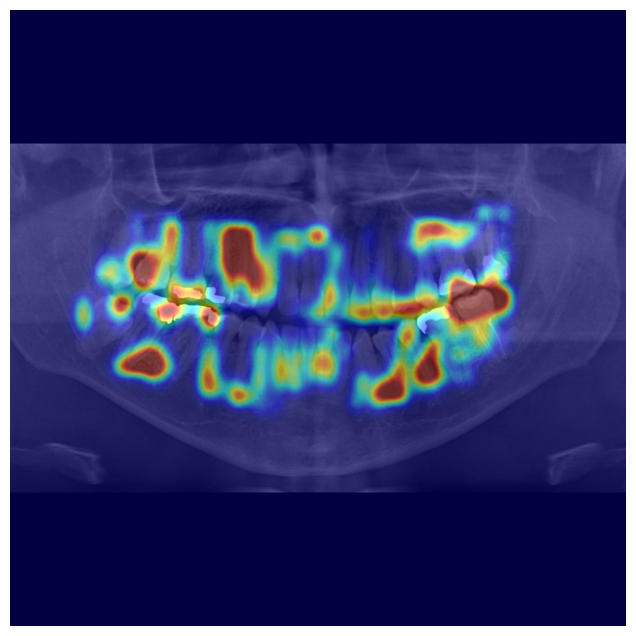

In [9]:
# Ejemplo de aplicación: generar Grad-CAM sobre una imagen de prueba

image_id = random.choice(teeth_dataset_test.image_ids) # Seleccionar ID de imagen
original_image, image_meta, _, _, _ = modellib.load_image_gt(
    teeth_dataset_test, inference_config, image_id
)

# Preprocesar la imagen antes de la detección
molded_images, image_metas, windows = model.mold_inputs([original_image])
anchors = model.get_anchors(molded_images[0].shape)

# Obtener predicciones del modelo
results = model.detect([original_image], verbose=0)
r = results[0]

# Generar un mapa de activación Grad-CAM combinado
combined_cam = np.zeros(original_image.shape[:2], dtype=np.float32)
score_threshold = 0.5  # Umbral de score para filtrar detecciones poco confiables

# Iterar sobre las detecciones para calcular Grad-CAM en cada una
for bbox_index in range(len(r["rois"])):
    score = r["scores"][bbox_index]
    if score < score_threshold:
        continue

    # Calcular Grad-CAM para la detección actual
    cam = compute_gradcam(model, original_image, molded_images[0], image_metas[0], anchors, r, bbox_index)
    y1, x1, y2, x2 = r["rois"][bbox_index]
    cam_resized = cv2.resize(cam, (x2 - x1, y2 - y1)) * score
    combined_cam[y1:y2, x1:x2] += cam_resized

# Aplicar filtro gaussiano para suavizar el mapa de calor
combined_cam = scipy.ndimage.gaussian_filter(combined_cam, sigma=10)

# Normalizar el mapa de calor utilizando percentil para evitar saturaciones
p99 = np.percentile(combined_cam, 99)
combined_cam = np.clip(combined_cam, 0, p99) / (p99 if p99 > 0 else 1)

# Convertir el mapa de calor en una imagen coloreada
heatmap_color = cv2.applyColorMap(np.uint8(255 * combined_cam), cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

overlay_image = original_image.astype(np.float32)
alpha = 0.5  # Transparencia de la superposición
overlay_image = np.uint8(np.clip(alpha * overlay_image + (1 - alpha) * heatmap_color, 0, 255))

# Visualización Grad-CAM
plt.figure(figsize=(8, 8))
plt.imshow(overlay_image, cmap="gray")
plt.axis("off")
plt.show()